### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import time

### Original Optimized

In [2]:
def trainSOM(input_data, n_max_iterations, width, height):
    
    radius_0 = max(width, height) / 2
    lr_0 = 0.1
    weights = np.random.random((width, height, 3)) # Shape: (width, height, 3)
    lambda_val = n_max_iterations / np.log(radius_0) # Shape: (0) Scalar

    # Precompute grid coordinates
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height), indexing='ij') # Shape: (width, height), (width height)
    grid = np.stack([x_coords, y_coords], axis=-1)  # Shape: (width, height, 2)

    for t in range(n_max_iterations):
        if t % 10 == 0:
            print(f"Iteration: {t}")

        radius_t = radius_0 * np.exp(-t / lambda_val) # Shape: (0) Scalar
        lr_t = lr_0 * np.exp(-t / lambda_val) # Shape: (0) Scalar

        for vt in input_data:
            # Compute distance from vt to each neuron
            distances = np.linalg.norm(weights - vt, axis=2) # Shape: (width, height, 3)
            bmu_index = np.unravel_index(np.argmin(distances), (width, height))
            bmu_vector = np.array(bmu_index) # Shape: (2,)

            # Compute neighborhood function
            diff = grid - bmu_vector  # Shape: (width, height, 2)
            dist_sq = np.sum(diff ** 2, axis=2)  # Shape: (width, height)
            influence_t = np.exp(-dist_sq / (2 * radius_t**2))  # Shape: (width, height)

            # Update weights using broadcasting
            influence = lr_t * influence_t[..., np.newaxis]  # Shape: (width, height, 1)
            weights += influence * (vt - weights)

    return weights


### Class Optimized

### Class

In [3]:
# kohonen_update.py

class KohonenTrainer:

    def __init__(self, n_max_iterations, width, height):

        self.n_max_iterations = n_max_iterations
        self.width = width
        self.height = height

        self.radius_0 = max(self.width, self.height) / 2
        self.lr_0 = 0.1
        self.lambda_val = self.n_max_iterations / np.log(self.radius_0)

        self.constants = {}

        for t in range(self.n_max_iterations):
            self.constants[t] = {"lr_t": self.learning_rate(t),
                                 "radius_t": self.neighbour_radius(t)}

    def calculate_bmu(self, weights, row_vector):
        bmu = np.argmin(np.sum((weights - row_vector) ** 2, axis=2))
        return np.unravel_index(bmu, (self.width, self.height))
    
    def influence(self, dist, radius_t):
        return np.exp(-(dist ** 2) / (2*(radius_t ** 2)))

    def euclidean_distance(self, point1, point2):
        return np.sqrt(((point1[0] - point2[0]) ** 2) + ((point1[1] - point2[1]) ** 2))
    
    def neighbour_radius(self, t):
        return self.radius_0 * np.exp(-t/self.lambda_val)

    def learning_rate(self, t):
        return self.lr_0 * np.exp(-t/self.lambda_val)
    
    def train(self, input_data):
        weights = np.random.random((self.width, self.height, 3))
        
        for t in range(self.n_max_iterations):
            # if t % 100 == 0:
            print(f"Iteration: {t}/{self.n_max_iterations}")
                
            lr_t = self.constants[t]["lr_t"]
            radius_t = self.constants[t]["radius_t"]
            
            for vt in input_data:    
                bmu_x, bmu_y = self.calculate_bmu(weights, vt)

                # Bounding box around the neighbourhood radius
                window_top_left = [max(bmu_x - int(radius_t), 0), max(bmu_y - int(radius_t), 0)]
                window_bottom_right = [min(bmu_x + int(radius_t), self.width), min(bmu_y + int(radius_t), self.height)]
                
                for x in range(window_top_left[0], window_bottom_right[0]):
                    for y in range(window_top_left[1], window_bottom_right[1]):
                        
                        distance = self.euclidean_distance([x,y], [bmu_x, bmu_y])
                        if distance <= radius_t:
                            influence_t = self.influence(distance, radius_t)
                            weights[x, y] += lr_t * influence_t * (vt - weights[x, y])
        return weights


### Testing

In [4]:
data_count = [10, 100]
map_size = [10, 100, 1000]
iterations = [10, 100]

data_dimensions = 3

In [5]:
output_dict = {}
output_names = {}

count = 0

total_start = time.time()

for c in data_count:
    for d in map_size:
        for i in iterations:
            input_data = input_data = np.random.random((c, data_dimensions))

            print("\n")
            print(f"Row Count: {c}, Map Size: {d}, Iteration: {i}")
            
            image_key = f"image_{i}_{d}x{d}"
            time_key = f"time_{i}_{d}x{d}"
            output_names[count] = [image_key, time_key, c, d, i]
            
            start = time.time()
            output_dict[output_names[count][0]] = trainSOM(input_data, i, d, d)
            end = time.time()
            output_dict[output_names[count][1]] = end - start

            count += 1

total_end = time.time()



Row Count: 10, Map Size: 10, Iteration: 10
Iteration: 0


Row Count: 10, Map Size: 10, Iteration: 100
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


Row Count: 10, Map Size: 100, Iteration: 10
Iteration: 0


Row Count: 10, Map Size: 100, Iteration: 100
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


Row Count: 10, Map Size: 1000, Iteration: 10
Iteration: 0


Row Count: 10, Map Size: 1000, Iteration: 100
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


Row Count: 100, Map Size: 10, Iteration: 10
Iteration: 0


Row Count: 100, Map Size: 10, Iteration: 100
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


Row Count: 100, Ma

### Output

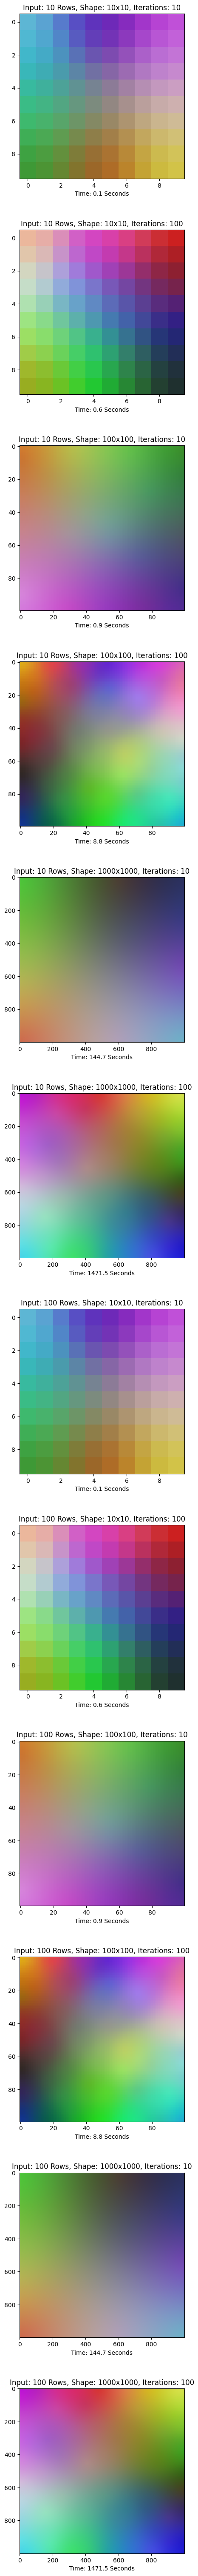

In [6]:
fig, axes = plt.subplots(count, 1, figsize=(5,6*(count + 1)))

for x in range(count):

    image = output_dict[output_names[x][0]]
    row = output_names[x][2]
    size = output_names[x][3]
    iter_count = output_names[x][4]
    time_taken = round(output_dict[output_names[x][1]], 1)
    name = f"{row}Rows_{size}x{size}Map_{iter_count}Iters_{time_taken}Time"
    file_name = f"outputs/{name}.png"

    plt.imsave(file_name, image)
    
    axes[x].imshow(image)
    axes[x].set_title(f"Input: {row} Rows, Shape: {size}x{size}, Iterations: {iter_count}")
    axes[x].set_xlabel(f"Time: {time_taken} Seconds")

plt.show()

In [7]:
total_time = total_end - total_start
print(f"Total Time Taken: {total_time}")

Total Time Taken: 1783.9648616313934
